In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy.io import arff

pd.set_option('display.max_columns', None)

In [2]:
path = r'D:\Studies\Fourth Semester\Autonomous Systems A\ML model\NSL-KDD new dataset\KDDTrain+.arff'
data, meta = arff.loadarff(path)

# Convert to DataFrame
df = pd.DataFrame(data)

# Decode byte strings
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode('utf-8')

# Show first few rows
print(df.describe(include='all'))

            duration protocol_type service    flag     src_bytes  \
count   125973.00000        125973  125973  125973  1.259730e+05   
unique           NaN             3      70      11           NaN   
top              NaN           tcp    http      SF           NaN   
freq             NaN        102689   40338   74945           NaN   
mean       287.14465           NaN     NaN     NaN  4.556674e+04   
std       2604.51531           NaN     NaN     NaN  5.870331e+06   
min          0.00000           NaN     NaN     NaN  0.000000e+00   
25%          0.00000           NaN     NaN     NaN  0.000000e+00   
50%          0.00000           NaN     NaN     NaN  4.400000e+01   
75%          0.00000           NaN     NaN     NaN  2.760000e+02   
max      42908.00000           NaN     NaN     NaN  1.379964e+09   

           dst_bytes    land  wrong_fragment         urgent            hot  \
count   1.259730e+05  125973   125973.000000  125973.000000  125973.000000   
unique           NaN       

In [3]:
# Check for missing values
print(df.isnull().sum())

#Drop always Zero columns
df = df.drop(['num_outbound_cmds', 'is_host_login', 'is_guest_login'], axis=1)



duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [4]:
#encoding the class column

le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
y=df['class']


In [5]:

categorical_cols=df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['protocol_type', 'service', 'flag', 'land', 'logged_in'], dtype='object')


In [6]:
# One-hot encoding categorical features
encoder = OneHotEncoder(sparse=False) 
encoded_categories = encoder.fit_transform(df[['protocol_type', 'service', 'flag', 'land', 'logged_in']])

encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['protocol_type', 'service', 'flag', 'land', 'logged_in']))

X_copy = df.copy()

# Drop the original categorical columns and concatenate encoded ones
X_copy.drop(columns=['protocol_type', 'service', 'flag', 'land', 'logged_in'], inplace=True)

X_full = pd.concat([X_copy, encoded_df], axis=1)

# Now drop the target column 'class' from X_full
X_full = X_full.drop(['class'], axis=1)

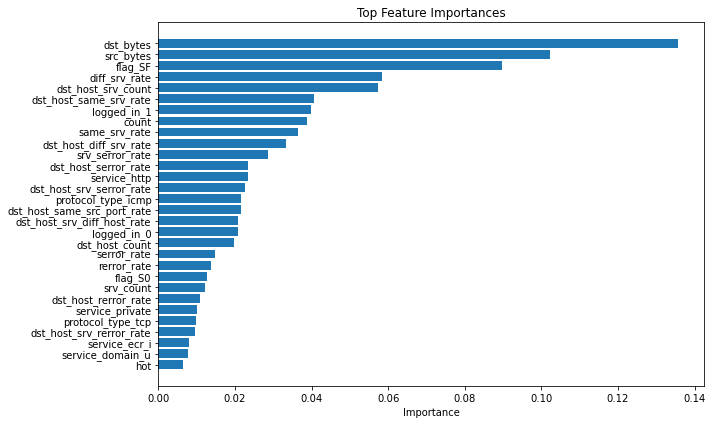

In [7]:

rf = RandomForestClassifier(
    n_estimators=100,          # number of trees
    max_depth=10,              # limit tree depth to avoid overfitting
    min_samples_split=10,      # require more samples to split
    min_samples_leaf=5,        # require more samples per leaf
    max_features='sqrt',       # fewer features per split
    random_state=42
)
rf.fit(X_full, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_full.columns

# Create a pandas DataFrame for importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

top_n = 30
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.barh(feature_importance_df['feature'][:top_n][::-1], feature_importance_df['importance'][:top_n][::-1])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [8]:
test_path = r'D:\Studies\Fourth Semester\Autonomous Systems A\ML model\NSL-KDD new dataset\KDDTest+.arff'
data_test, meta_test = arff.loadarff(test_path)
df_test = pd.DataFrame(data_test)

# Decode byte strings as before
for col in df_test.select_dtypes([object]):
    df_test[col] = df_test[col].str.decode('utf-8')
# One-hot encode categorical columns in test set using the SAME encoder fitted on training data
encoded_categories_test = encoder.transform(df_test[['protocol_type', 'service', 'flag', 'land', 'logged_in']])

encoded_df_test = pd.DataFrame(encoded_categories_test, columns=encoder.get_feature_names_out(['protocol_type', 'service', 'flag', 'land', 'logged_in']))

df_test_copy = df_test.copy()

df_test_copy.drop(columns=['protocol_type', 'service', 'flag', 'land', 'logged_in','num_outbound_cmds', 'is_host_login', 'is_guest_login'], inplace=True)

X_test_full = pd.concat([df_test_copy, encoded_df_test], axis=1)

# Drop target column from test features
X_test_full = X_test_full.drop(['class'], axis=1)

# Extract labels from test set
y_test = df_test['class']


y_test_encoded = le.transform(y_test)  # <-- just transform, no fit again
y_pred = rf.predict(X_test_full)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred))

Accuracy: 0.7583836053938964
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     12833
           1       0.65      0.97      0.78      9711

    accuracy                           0.76     22544
   macro avg       0.81      0.78      0.76     22544
weighted avg       0.83      0.76      0.75     22544



Try increasing the Accuracy 
Use XGboost
PCA
scale values in data set
check feature importance and correlation to decrease dimensionality of the data
